# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: ML Modell erstellen

Hier in diesem Notebook erstellen wir unsere Machine Learning Modelle.

---

# Libraries Importieren

In [1]:
# CODE

# Data Science Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn Libraries

## import logistic regression
from sklearn.linear_model import LogisticRegression

## Train Validation Split
from sklearn.model_selection import train_test_split

## import metrics 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Decision Tree

## Random Forest



# Daten einlesen

In [29]:
# CODE

# File: Alle_Messungen.csv (Raw Data) einlesen
raw_unprocessed_data = pd.read_csv("..\Sensor_Data-Wrangling-und-EDA\Alle_Messungen.csv", index_col=0)

# get information about raw_unprocessed_data
raw_unprocessed_data.info()

# display head 
raw_unprocessed_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2539533 entries, 0 to 2539532
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   time             object 
 1   Accelerometer_x  float64
 2   Accelerometer_y  float64
 3   Accelerometer_z  float64
 4   Gyroscope_x      float64
 5   Gyroscope_y      float64
 6   Gyroscope_z      float64
 7   Magnetometer_x   float64
 8   Magnetometer_y   float64
 9   Magnetometer_z   float64
 10  Orientation_qx   float64
 11  Orientation_qy   float64
 12  Orientation_qz   float64
 13  id               object 
 14  user             object 
 15  class            object 
 16  id_combined      object 
dtypes: float64(12), object(5)
memory usage: 348.8+ MB


,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,2023-02-27 15:02:04.548,0.000,-3.552,-9.140,NaN,NaN,NaN,NaN,NaN,NaN,0.161765,-0.088290,-0.470671,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
1,2023-02-27 15:02:17.156,0.000,9.722,1.278,NaN,NaN,NaN,NaN,NaN,NaN,-0.217750,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
2,2023-02-27 15:02:31.574,-0.728,9.779,0.000,NaN,NaN,NaN,NaN,NaN,NaN,-0.420650,0.568356,-0.598058,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
3,2023-02-27 15:02:16.685,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,43.5,-13.143750,NaN,NaN,NaN,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
4,2023-02-27 15:02:32.295,NaN,NaN,NaN,NaN,NaN,NaN,-13.012501,0.0,20.587502,NaN,NaN,NaN,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


# Baseline Modell 

Im Baseline Modell verwenden wir die unprozessierten Daten.  
Dabei werden die NaN Zeilen entfernt und anschliessend im Verhältnis 80:20 in Trainings- und Validierungsdaten aufgeteilt. 

Anschliessend wird ein Decision Tree Classifier Modell erstellt, trainiert und anschliessend mittels validierungs Daten die Accuracy Metrik berechnet und die Klassifizierungen mittels einer Confusion Matrix dargestellt. 

Bemerkung: 
Die Gewichtung der Klassen werden im Baseline Modell nicht mit berücksichtigt.


### Raw Daten verarbeiten 

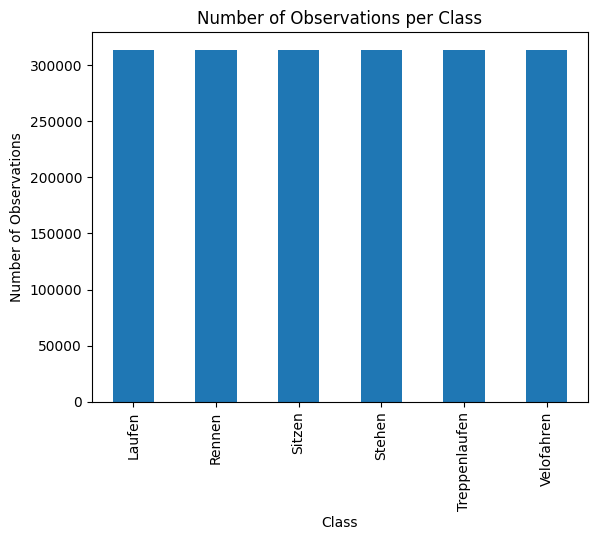

In [37]:
# remove na rows from raw_unprocessed_data
raw_unprocessed_data = raw_unprocessed_data.dropna(axis = 0)

# drop uneccessary columns for the baseline modell
baseline_data = raw_unprocessed_data.drop(['time', 'id', 'user', 'id_combined'], axis = 1)

# get the number of observation for each class and select the minimum
min_class = baseline_data['class'].value_counts().min()

# Select the min_class of each class to get an equal number of observations for each class
baseline_data = baseline_data.groupby('class').sample(n = min_class, random_state=42)

baseline_data['class'].value_counts().plot(kind = "bar")
plt.xlabel("Class")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Class")
plt.show()

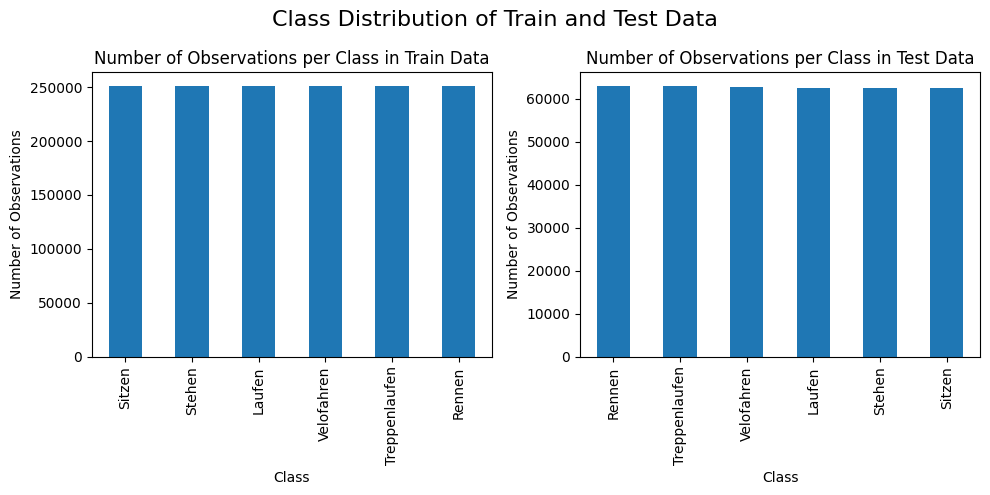

In [51]:
# split the data into baselin_train_X, baseline_train_y, baseline_test_X, baseline_test_y 
baseline_train_X, baseline_test_X, baseline_train_y, baseline_test_y = train_test_split(baseline_data.drop('class', axis = 1), baseline_data['class'], test_size = 0.2, random_state = 42)

# plot the class distribution of the baseline_train_y and baseline_test_y in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
baseline_train_y.value_counts().plot(kind = "bar", ax = ax1)
ax1.set_xlabel("Class")
ax1.set_ylabel("Number of Observations")
ax1.set_title("Number of Observations per Class in Train Data")
baseline_test_y.value_counts().plot(kind = "bar", ax = ax2)
ax2.set_xlabel("Class")
ax2.set_ylabel("Number of Observations")
ax2.set_title("Number of Observations per Class in Test Data")
fig.suptitle("Class Distribution of Train and Test Data", fontsize = 16)
plt.tight_layout()
plt.show()


The accuracy of the logistic regression model is:  0.3061181658785399


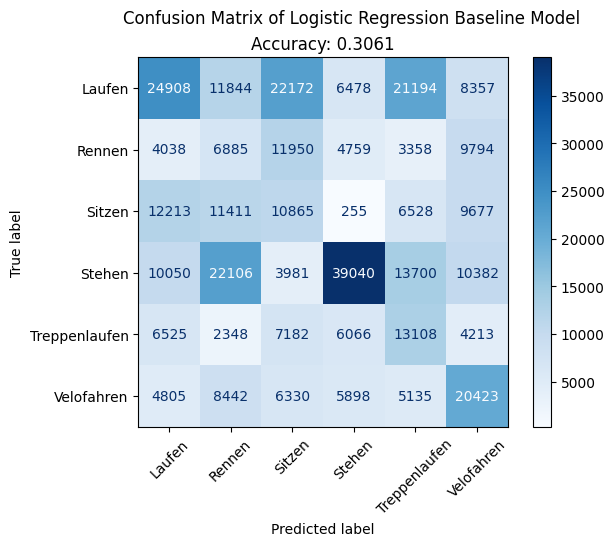

In [77]:
# create a logistic regression model for multiclass classification
logistic_regression = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", max_iter = 1000)

# fit the logistic regression model
logistic_regression.fit(baseline_train_X, baseline_train_y)

# predict the classes for the test data
baseline_test_y_pred = logistic_regression.predict(baseline_test_X)

# calculate the accuracy of the logistic regression model
baseline_test_accuracy = accuracy_score(baseline_test_y, baseline_test_y_pred)

# print the accuracy of the logistic regression model
print("The accuracy of the logistic regression model is: ", baseline_test_accuracy)

# plot the confusion matrix of the logistic regression model
cm = confusion_matrix(baseline_test_y_pred, baseline_test_y)

# create a confusion matrix display with title 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_regression.classes_)
disp.plot(cmap = "Blues", values_format = "d")

plt.suptitle("Confusion Matrix of Logistic Regression Baseline Model")
# add accuracy as subtitle
plt.title("Accuracy: " + str(round(baseline_test_accuracy, 4)), fontsize = 12)
# rotate x ticks
plt.xticks(rotation = 45)
plt.show()



In [76]:
# create a confusion matrix display with title 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_regression.classes_)
disp.plot(cmap = "Blues", values_format = "d")

plt.suptitle("Confusion Matrix of Logistic Regression Baseline Model")
# add accuracy as subtitle
plt.title("Accuracy: " + str(round(baseline_test_accuracy, 4)), fontsize = 12)
# rotate x ticks
plt.xticks(rotation = 45)
plt.show()

TypeError: plot() got an unexpected keyword argument 'transpose'

In [4]:
# create a model
baseline_model = LogisticRegression()

# fit the model
baseline_model.fit(baseline_data_X, baseline_data_y)

# predict the model
baseline_model_pred = baseline_model.predict(baseline_data_val)

# get all unique values from baseline_model_pred
baseline_model_pred_unique = pd.Series(baseline_model_pred).unique()

# calculate accuracy score
baseline_model_accuracy = accuracy_score(baseline_data_val_y, baseline_model_pred)

print('baseline model accuracy: ', baseline_model_accuracy)

# plot confusion matrix for baseline model with seaborn
# create confusion matrix
baseline_model_confusion_matrix = confusion_matrix(baseline_data_val_y, baseline_model_pred)

# plot confusion matrix
# plot with sklearn display confusion matrix
ConfusionMatrixDisplay(baseline_model_confusion_matrix, display_labels=baseline_model.classes_)


c:\Users\Si Ben Tran\venv\cdl1\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


baseline model accuracy:  0.37086406522725773


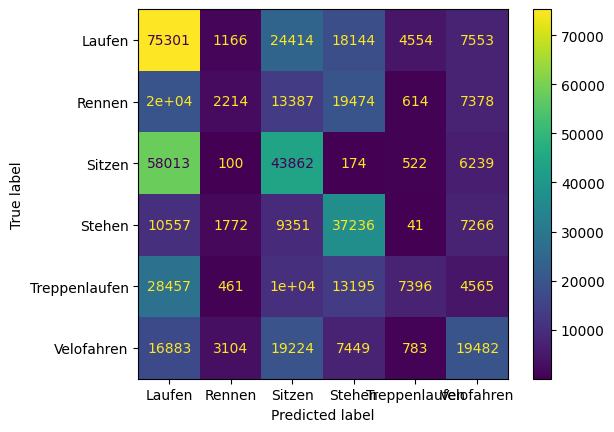

In [5]:
# display with sklearn confusionmatrixdispla with labels and plot
ConfusionMatrixDisplay(baseline_model_confusion_matrix, display_labels=baseline_model.classes_, ).plot()


---
# Modell-01 - Decision Tree

In [6]:
# CODE

# Modell erstellen

# Modell trainieren

# Modell Accuracy mittels Validierungsdatensatz

# Confusion Matrix erstellen

## Fazit zu Modell-01 - Decision Tree

blabla

---

# Modell-02 - Random Forest

In [7]:
# CODE

# Modell erstellen

# Modell trainieren

# Modell Accuracy mittels Validierungsdatensatz

# Confusion Matrix erstellen

## Fazit zu Modell-02 - Random Forest

blabla

---

# Modelle vergleichen


In [8]:
# CODE

# Barplot erstellen x-Achse = Modelle, y-Achse = Accuracy Score



## Fazit zu ML Modelle 

blabla

---